In [1]:
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame

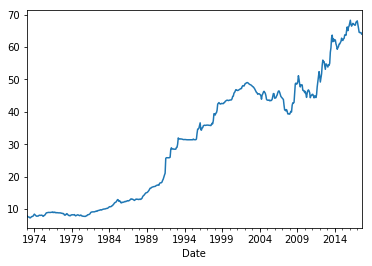

In [69]:
names=["Date","Value"]
series = read_csv('INR-vs-USD.csv',index_col=0,names=names,header=0)
series.index = pd.to_datetime(series.index)
resampled_series = series['Value'].resample('MS').mean() #Resample with Month Start frequency
resampled_series.plot()

In [3]:
resampled_series.head()

Date
1973-01-01    8.004091
1973-02-01    7.753750
1973-03-01    7.546500
1973-04-01    7.546190
1973-05-01    7.492727
Freq: MS, Name: Value, dtype: float64

In [110]:
train_size=int(len(resampled_series)*19/20)
print(train_size)
test_size=len(resampled_series)-train_size
print(test_size)

509
27


In [138]:
#train_data=resampled_series[:train_size]
train_data=resampled_series[:]
test_data=resampled_series[train_size:]
print(train_data)

Date
1973-01-01     8.004091
1973-02-01     7.753750
1973-03-01     7.546500
1973-04-01     7.546190
1973-05-01     7.492727
                ...    
2017-04-01    64.536000
2017-05-01    64.419545
2017-06-01    64.448182
2017-07-01    64.424000
2017-08-01    63.970526
Freq: MS, Name: Value, Length: 536, dtype: float64


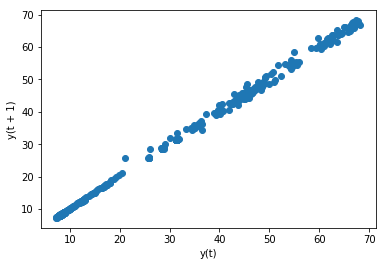

In [139]:
lag_plot(resampled_series)

In [140]:
model = ARIMA(resampled_series, order=(10,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  535
Model:                ARIMA(10, 1, 0)   Log Likelihood                -472.433
Method:                       css-mle   S.D. of innovations              0.585
Date:                Wed, 05 Feb 2020   AIC                            968.867
Time:                        17:05:34   BIC                           1020.254
Sample:                    02-01-1973   HQIC                           988.972
                         - 08-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1032      0.037      2.794      0.005       0.031       0.176
ar.L1.D.Value      0.3252      0.043      7.534      0.000       0.241       0.410
ar.L2.D.Value     -0.0848      0.045

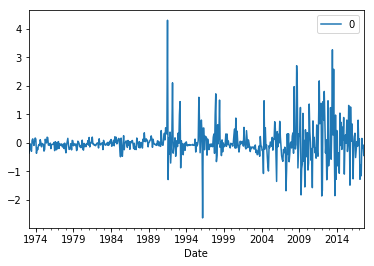

In [141]:
residuals = DataFrame(model_fit.resid)
residuals.plot()


                0
count  535.000000
mean     0.000280
std      0.585554
min     -2.629039
25%     -0.178940
50%     -0.045337
75%      0.107041
max      4.302800


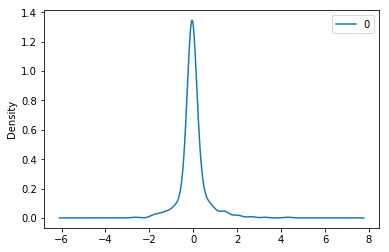

In [142]:
residuals.plot(kind='kde')
print(residuals.describe())

In [143]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(resampled_series)

Results of Dickey-Fuller Test:
Test Statistic                   0.289968
p-value                          0.976880
#Lags Used                      17.000000
Number of Observations Used    518.000000
Critical Value (1%)             -3.443037
Critical Value (5%)             -2.867136
Critical Value (10%)            -2.569750
dtype: float64


In [144]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(resampled_series)


Results of KPSS Test:
Test Statistic            2.658814
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/linu/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/linu/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


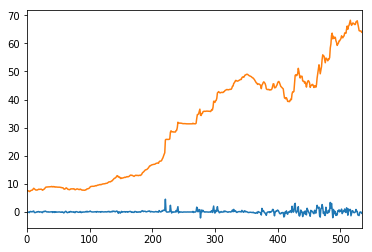

In [145]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

diff=difference(resampled_series)
diff.plot()

def inverse_difference(last_ob, value):
	return value + last_ob

inverted = [inverse_difference(resampled_series[i], diff[i]) for i in range(len(diff))]
inverted=pd.Series(inverted)
inverted.plot()

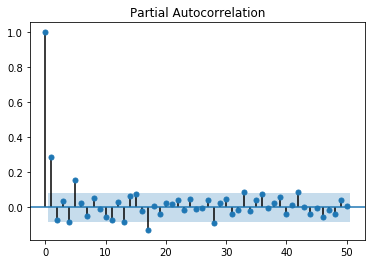

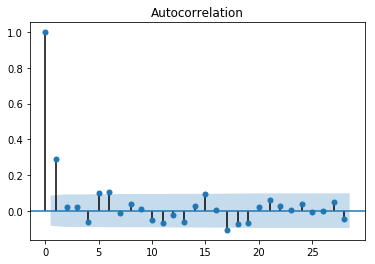

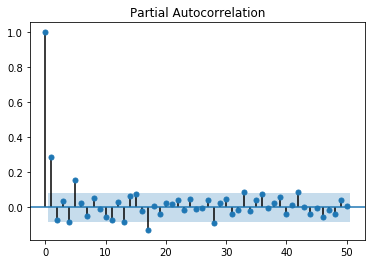

In [146]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(diff)
plot_pacf(diff, lags=50)

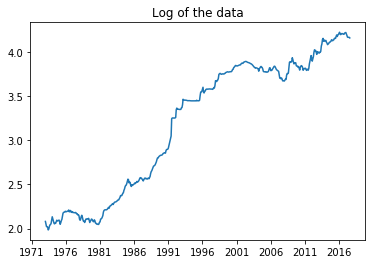

In [147]:
import numpy as np
ts_log = np.log(resampled_series)
plt.title('Log of the data')
plt.plot(ts_log)
plt.show()

In [159]:
import statsmodels.api as sm
# walk-forward validation
history = [x for x in train_data]
predictions = list()

def StartARIMAForecasting(Actual, P, D, Q):
    model = sm.tsa.statespace.SARIMAX(Actual,
                                order=(2, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)             

    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction
    """
    model = ARIMA(Actual, order=(2, 1, 1))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction"""


for i in range(len(test_data)):
	# predict
	yhat = StartARIMAForecasting(history,2,1,2)
	predictions.append(yhat)
	# observation
	obs = test_data[i]
	history.append(obs)
	print('>Predicted=%f, Expected=%f' % (yhat, obs))


>Predicted=63.779365, Expected=63.780909
>Predicted=63.790647, Expected=63.604545
>Predicted=63.546717, Expected=65.097143
>Predicted=65.639824, Expected=66.166667
>Predicted=66.358467, Expected=65.026190
>Predicted=64.597686, Expected=66.100000
>Predicted=66.555531, Expected=66.502273
>Predicted=66.397613, Expected=67.333158
>Predicted=67.707846, Expected=68.239500
>Predicted=68.384859, Expected=66.890870
>Predicted=66.458606, Expected=66.421905
>Predicted=66.400303, Expected=66.889524
>Predicted=66.993321, Expected=67.265455
>Predicted=67.364977, Expected=67.158000
>Predicted=67.134959, Expected=66.903478
>Predicted=66.867587, Expected=66.713810
>Predicted=66.623603, Expected=66.741500
>Predicted=66.805774, Expected=67.639500
>Predicted=67.920148, Expected=67.805238
>Predicted=67.793084, Expected=68.047368
>Predicted=68.192076, Expected=66.972632
>Predicted=66.514377, Expected=65.800870
>Predicted=65.580284, Expected=64.536000
>Predicted=64.143020, Expected=64.419545
>Predicted=64.52

In [158]:
mse = mean_squared_error(test_data, predictions)
rmse = sqrt(mse)
print('MSE:%.3f' % mse)
print('RMSE: %.3f' % rmse)

MSE:0.549
RMSE: 0.741
